In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device : {device}")

c:\py\Anaconda3\envs\proximity_cf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device : cpu


## Models

- model definition 
- weight loading

In [5]:
## model definition

import torch.nn as nn

class NineLayerMLP(nn.Module):
    def __init__(self, input_dim):
        super(NineLayerMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(0.1),

            # output layer
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# model loading

model_load1 = NineLayerMLP(input_dim=21)
model_load1.load_state_dict(torch.load(
    '../results/Weights/model1_smotetraining.pth',
    map_location='cpu'
))
model_load1.eval()

NineLayerMLP(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=64, out_features=32, bias=True)
    (12): ReLU()
    (13): Linear(in_features=32, out_features=32, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=32, out_features=16, bias=True)
    (17): ReLU()
    (18): Linear(in_features=16, out_features=16, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.1, inplace=False)
    (21): Linear(in_features=16, out_features=1, bias=True)
    (22): Sigmoid()
  )
)

## Dataset

In [8]:
import pandas as pd

file_path1 = '../Datasets/diabetes_binary_health_indicators_BRFSS2015.csv'

df1 = pd.read_csv(file_path1)

# shuffle
from sklearn.utils import shuffle

df1 = shuffle(df1, random_state=42).reset_index(drop=True)

# drop duplicates
df1 = df1.drop_duplicates()

import numpy as np
from sklearn.model_selection import train_test_split

# dataset 1 splitting
X1_df = df1.drop(columns=['Diabetes_binary'])  
X1 = X1_df.values.astype(np.float32)       
y1 = df1['Diabetes_binary'].values.astype(np.float32)    

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

X_train_tensor1 = torch.tensor(X_train1)
y_train_tensor1 = torch.tensor(y_train1).view(-1, 1)
X_test_tensor1 = torch.tensor(X_test1)
y_test_tensor1 = torch.tensor(y_test1).view(-1, 1)

## Pipeline

- ML classifier
- Interface
- AI expainer (LIME / SHAP) 
    - LIME : (https://safjan.com/lime-tutorial/), (https://github.com/marcotcr/lime)
    - SHAP : https://shap.readthedocs.io/en/latest/
- Dice (https://interpret.ml/DiCE/notebooks/DiCE_model_agnostic_CFs.html)
- counterfactual examples

## User-feedback constraints

- two steps method
    - before DiCE : filter features which can be changed
    - after DiCE : visualize some linear constraints (e.g. for BMI)
        - use PCA first;
        - map constraints on 2-D space;

In [9]:
print(df1.columns.tolist())

['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [ ]:
modifiable_features = [
    'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 
    'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Education', 'Income'
]

In [11]:
whole_features = df1.columns.tolist()

print(set(modifiable_features).issubset(set(whole_features)))

True


## Scatter plot for LIME & SHAP

LIME and SHAP comparison :

- 100 samples from dataset1 (0 -> 1)

### For Dataset 1

In [12]:
## we can prepare index list at first 

### for dataset 1
import torch
import numpy as np

target_class = 0           
threshold = 0.5           

model_load1.eval()
with torch.no_grad():
    probs = model_load1(X_test_tensor1.to(device)).cpu().numpy().flatten()

if target_class == 0:
    indices = np.where(probs < threshold)[0]
else:
    indices = np.where(probs >= threshold)[0]

# store in list
negative_indices_1 = indices.tolist()

print(len(negative_indices_1))

38310


In [13]:
import re
import lime
import shap
import torch
import numpy as np
import dice_ml
from dice_ml import Dice
import pandas as pd
import lime.lime_tabular

c:\py\Anaconda3\envs\proximity_cf\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\py\Anaconda3\envs\proximity_cf\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

In [14]:
## for LIME and SHAP

def predict_fn_lime(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        probs = model_load1(x_tensor)
        probs = torch.cat([1 - probs, probs], dim=1)
        return probs.cpu().numpy()
    
def shap_predict_fn(x_numpy):
    with torch.no_grad():
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
        probs = model_load1(x_tensor)
        return torch.cat([1 - probs, probs], dim=1).cpu().numpy()

In [15]:
# LIME for dataset 1
## output --> feature list

def LIME_ds1(sample):
    ## LIME
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_tensor1.cpu().numpy(),
        feature_names=list(X1_df.columns),
        class_names=['No Diabetes', 'Diabetes'],
        mode='classification'
    )

    exp_lime = explainer_lime.explain_instance(
        data_row=sample.flatten(),
        predict_fn=predict_fn_lime,
        num_features=21
    )

    positive_feature_lime = [
        token for feature, weight in exp_lime.as_list() if weight < 0
        for token in re.split(r'\s|<|>|=', feature)
        if re.match(r'^[A-Za-z_]+$', token)
    ]

    return positive_feature_lime

In [ ]:
# SHAP for dataset1
## output --> feature list

def SHAP_ds1(sample):

    background = X_train_tensor1[:100].cpu().numpy()

    explainer_shap = shap.KernelExplainer(
        model=shap_predict_fn,
        data=background
    )

    shap_values = explainer_shap.shap_values(sample)
    shap_value_class1 = shap_values[1][0]
    feature_names = list(X1_df.columns)
    positive_features = [
        (name, value)
        for name, value in zip(feature_names, shap_value_class1)
        if value < 0
    ]

    positive_feature_names = [name for name, value in positive_features]

    return positive_feature_names
    

In [17]:
# DiCE
## input --> featrues list
## output --> counterfactual example sets

class PyTorchWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model.eval()

    def forward(self, input_tensor):
        return self.model(input_tensor)

    def predict_proba(self, input_data):
        if isinstance(input_data, pd.DataFrame):
            input_data = input_data.values

        if isinstance(input_data, np.ndarray):
            input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
        else:
            raise ValueError("Unsupported input type for predict_proba")

        with torch.no_grad():
            output = self.model(input_tensor)  
            probs = torch.cat([1 - output, output], dim=1)
        return probs.cpu().numpy()
    
import contextlib
import io
import warnings

def DICE_ds1(feature_names, sample):
    try:
        # human-feedback contraints
        if not set(feature_names).issubset(set(modifiable_features)):
            # print("This feature is not the subset!!!!!!!!!!!!!!")
            return None

        data_dice = dice_ml.Data(
            dataframe=df1,
            continuous_features=[col for col in df1.columns if col != 'Diabetes_binary'],
            outcome_name='Diabetes_binary'
        )

        model_wrapper = PyTorchWrapper(model_load1)
        model_dice = dice_ml.Model(model=model_wrapper, backend="PYT")
        dice = Dice(data_dice, model_dice)

        sample_df = pd.DataFrame(sample, columns=[col for col in df1.columns if col != 'Diabetes_binary'])

        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")  
                dice_exp = dice.generate_counterfactuals(
                    sample_df, 
                    total_CFs=1,
                    desired_class="opposite",
                    features_to_vary=feature_names,
                    verbose=False 
                )

        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is None or cf_df.empty:
            return None

        cf_df = cf_df.drop(columns=["Diabetes_binary"], errors="ignore")
        return cf_df

    except Exception as e:
        return None

In [18]:
# LIME again
## input --> counterfactual example
## output --> probability from LIME

def LIME_prob(cf_df):
    if isinstance(cf_df, pd.DataFrame):
        sample = cf_df.to_numpy()
    elif isinstance(cf_df, pd.Series):
        sample = cf_df.values.reshape(1, -1)
    elif isinstance(cf_df, np.ndarray):
        sample = cf_df.reshape(1, -1)
    else:
        raise TypeError("Unsupported input type")

    probs = predict_fn_lime(sample)  
    return probs[0][1]

In [19]:
# SHAP again
## input --> counterfactual example
## output --> probability from SHAP

def SHAP_prob(cf_df):
    if isinstance(cf_df, pd.DataFrame):
        sample = cf_df.to_numpy()
    elif isinstance(cf_df, pd.Series):
        sample = cf_df.values.reshape(1, -1)
    elif isinstance(cf_df, np.ndarray):
        sample = cf_df.reshape(1, -1)
    else:
        raise TypeError("Unsupported input type")

    probs = shap_predict_fn(sample)  
    return probs[0][1]

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comprison(shap_result, lime_result) -> None:

    indices = np.arange(len(shap_result))

    plt.figure(figsize=(14, 6))

    plt.scatter(indices, shap_result, facecolors='none', edgecolors='blue', label='SHAP CF predictions')
    plt.scatter(indices, lime_result, facecolors='none', edgecolors='red', label='LIME CF predictions')

    plt.axhline(y=0.5, color='green', linestyle='--', linewidth=2, alpha=0.8, label='Decision Boundary')

    plt.xticks(np.arange(0, len(shap_result), 10))

    plt.ylim(0.3, 0.8)
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Probabilities')
    plt.title('Comparison of SHAP and LIME Results with Decision Boundary')
    plt.legend()
    plt.show()

In [21]:
def limeshap_compare_ds1(
    num_sample,  # how many valid points we want
    shap_result=None,
    lime_result=None
):
    if shap_result is None:
        shap_result = []
    if lime_result is None:
        lime_result = []

    np.random.seed(42)
    tried_indices = set()
    max_attempts = 20000
    attempt = 0

    all_lime_cfs = []
    all_shap_cfs = []

    while len(shap_result) < num_sample and attempt < max_attempts:
        attempt += 1
        available_indices = list(set(negative_indices_1) - tried_indices)
        if not available_indices:
            break

        # index = np.random.choice(available_indices)
        index = sorted(available_indices)[-1]
        tried_indices.add(index)

        sample = X_test_tensor1[index].numpy().reshape(1, -1)

        LIME_positive = LIME_ds1(sample)
        SHAP_positive = SHAP_ds1(sample)

        cf_df_LIME = DICE_ds1(LIME_positive, sample)
        if cf_df_LIME is None:
            continue

        cf_df_SHAP = DICE_ds1(SHAP_positive, sample)
        if cf_df_SHAP is None:
            continue

        try:
            lime_prob = LIME_prob(cf_df_LIME)
            shap_prob = SHAP_prob(cf_df_SHAP)
        except Exception as e:
            continue

        lime_result.append(lime_prob)
        shap_result.append(shap_prob)

        cf_df_LIME["source_index"] = index
        cf_df_SHAP["source_index"] = index
        all_lime_cfs.append(cf_df_LIME)
        all_shap_cfs.append(cf_df_SHAP)

    if all_lime_cfs:
        lime_df_all = pd.concat(all_lime_cfs, ignore_index=True)
        lime_df_all.to_csv('./cf samples/LIME_counterfactuals_ds1_50.csv', index=False)

    if all_shap_cfs:
        shap_df_all = pd.concat(all_shap_cfs, ignore_index=True)
        shap_df_all.to_csv('./cf samples/SHAP_counterfactuals_ds1_50.csv', index=False)

    if len(shap_result) == 0:
        return

    plot_comprison(shap_result, lime_result)

## run

  0%|          | 0/1 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

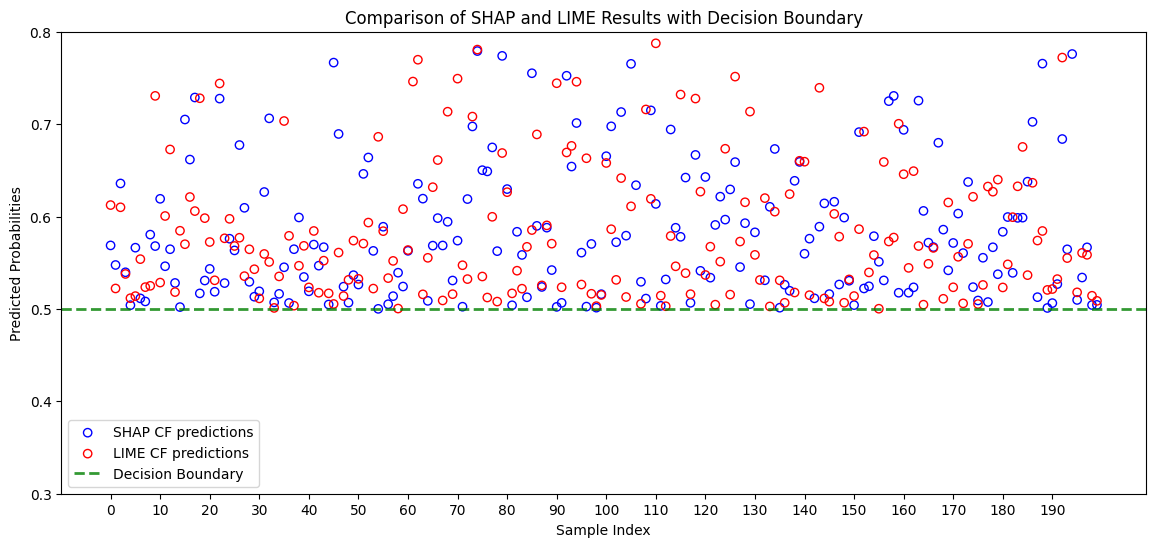

In [22]:
shap_result=[]
lime_result=[]

limeshap_compare_ds1(200, shap_result, lime_result)

In [23]:
import pandas as pd

lime_cfs = pd.read_csv("./cf samples/LIME_counterfactuals_ds1_50.csv")
shap_cfs = pd.read_csv("./cf samples/SHAP_counterfactuals_ds1_50.csv")

lime_cfs.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,source_index
0,1.0,1.0,1.0,64.1,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,3.0,0.0,30.0,0.0,1.0,12.0,5.0,7.0,45894
1,1.0,1.0,1.0,31.0,0.2,0.0,0.0,1.0,0.6,1.0,...,1.0,3.0,0.0,0.0,1.0,1.0,9.0,4.0,6.0,45863
2,1.0,1.0,1.0,31.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,3.0,0.0,3.0,0.5,1.0,9.0,5.0,5.4,45829
3,1.0,1.1,1.0,37.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,0.0,20.0,0.4,1.0,8.0,6.0,8.0,45821
4,1.0,0.0,1.0,88.7,0.0,0.0,0.0,0.5,0.0,1.0,...,0.0,3.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0,45812


## Post-DiCE human-feedback 

Just for visualization:

- Use PCA on the CF-datasets
- map the **BMI** constraints to a 2-D space


number of BMI illegal sample in LIME: 68 / 200
number of BMI illegal sample in SHAP: 76 / 200


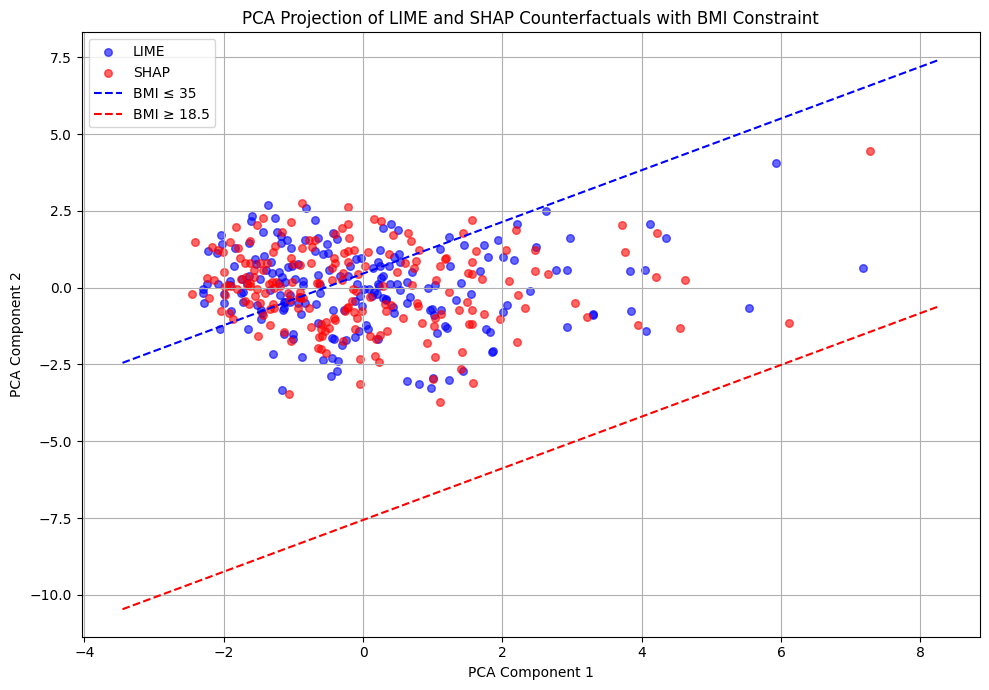

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

df1 = pd.read_csv("./cf samples/LIME_counterfactuals_ds1_50.csv")
df2 = pd.read_csv("./cf samples/SHAP_counterfactuals_ds1_50.csv")

df1 = df1.drop(columns=["source_index"], errors="ignore")
df2 = df2.drop(columns=["source_index"], errors="ignore")

df1["source"] = "LIME"
df2["source"] = "SHAP"

combined_df = pd.concat([df1, df2], ignore_index=True)

lime_df = combined_df[combined_df["source"] == "LIME"]
shap_df = combined_df[combined_df["source"] == "SHAP"]

lime_out_of_range = lime_df[(lime_df["BMI"] < 18.5) | (lime_df["BMI"] > 35)]
shap_out_of_range = shap_df[(shap_df["BMI"] < 18.5) | (shap_df["BMI"] > 35)]

print("number of BMI illegal sample in LIME:", len(lime_out_of_range), "/", len(lime_df))
print("number of BMI illegal sample in SHAP:", len(shap_out_of_range), "/", len(shap_df))

feature_cols = [col for col in combined_df.columns if col != "source"]
X = combined_df[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
Z = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
for label, color in zip(["LIME", "SHAP"], ["blue", "red"]):
    idx = combined_df["source"] == label
    plt.scatter(Z[idx, 0], Z[idx, 1], c=color, label=label, alpha=0.6, s=30)

if "BMI" in feature_cols:
    bmi_index = feature_cols.index("BMI")

    bmi_mean = X[:, bmi_index].mean()
    bmi_std = X[:, bmi_index].std()

    bmi_upper_std = (35 - bmi_mean) / bmi_std
    bmi_lower_std = (18.5 - bmi_mean) / bmi_std

    W = pca.components_.T  # shape: (n_features, 2)

    a_upper = np.zeros(len(feature_cols))
    a_upper[bmi_index] = 1
    a_lower = np.zeros(len(feature_cols))
    a_lower[bmi_index] = -1

    a_proj_upper = a_upper @ W
    a_proj_lower = a_lower @ W

    z1_range = np.linspace(Z[:, 0].min()-1, Z[:, 0].max()+1, 500)

    # BMI ≤ 35
    z2_upper = (bmi_upper_std - a_proj_upper[0] * z1_range) / (a_proj_upper[1] + 1e-9)
    plt.plot(z1_range, z2_upper, 'blue', linestyle='--', label='BMI ≤ 35')

    # BMI ≥ 18.5
    z2_lower = (bmi_lower_std - a_proj_lower[0] * z1_range) / (a_proj_lower[1] + 1e-9)
    plt.plot(z1_range, z2_lower, 'red', linestyle='--', label='BMI ≥ 18.5')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of LIME and SHAP Counterfactuals with BMI Constraint")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()